# **Predicting Match Outcomes in League of Legends Based on Team Performance and Player Statistics**

## **Introduction**

_League of Legends_ is a popular multiplayer online battle arena (MOBA) game developed and published by Riot Games that is played by well over 30 million players everyday on average. As a result of this, there is a wealth of game data available to gain insights about trends seen in League of Legends matches, as well as build a model that can predict the outcome of a game based on different match and player statistics.

In this analysis, I will begin by cleaning and pre-processing a League of Legends match dataset, after which I will perform an exploratory data analysis on the data, visualizing some key trends. Finally, I will use a CatBoost Classifier to predict match outcomes using the data available.

## **Data Description**

_License:_ **_CC BY 4.0 (Creative Commons Attribution 4.0 International)_**. \
This license allows sharing, modification, and use of the dataset as long as proper attribution is given.

The data that will be used is the `League of Legends Match Dataset (2025)` by user Jacob Krasuski from Kaggle.com: https://www.kaggle.com/datasets/jakubkrasuski/league-of-legends-match-dataset-2025

The dataset consists of 40412 rows and 94 columns, with each row representing a unique player in a match and each column representing information about various aspects regarding the match and the player's performance within the match. All of the data was taken from matches on the Europe Nordic and East server.

## **Data Cleaning**

remove unncessary columns, change monkeyking to wukong, change utility to support, remove nan, split into aram/sr/swiftplay,

In [10]:
# importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, Pool, cv 
from sklearn.model_selection import train_test_split
from numpy import random
from tabulate import tabulate
import shap

In [12]:
# loading in the dataset

matches = pd.read_csv("league_data.csv", dtype={17: 'str'}, parse_dates=['game_start_utc'])

In [13]:
matches.head(5)

,game_id,game_start_utc,game_duration,game_mode,game_type,game_version,map_id,platform_id,queue_id,participant_id,...,final_magicPen,final_magicPenPercent,final_magicResist,final_movementSpeed,final_omnivamp,final_physicalVamp,final_power,final_powerMax,final_powerRegen,final_spellVamp
0,3.727443e+09,2025-01-15 14:56:00,1714.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,5.0,...,0.0,0.0,48.0,385.0,0.0,0.0,799.0,1134.0,147.0,0.0
1,3.726377e+09,2025-01-13 10:50:00,1300.0,CLASSIC,MATCHED_GAME,15.1.648.3927,11.0,EUN1,420.0,5.0,...,0.0,0.0,38.0,390.0,0.0,0.0,970.0,970.0,105.0,0.0
2,3.729644e+09,2025-01-19 18:15:00,2019.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,2.0,...,0.0,0.0,121.0,431.0,0.0,0.0,10000.0,10000.0,0.0,0.0
3,3.729916e+09,2025-01-20 01:27:00,1625.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,8.0,...,12.0,0.0,47.0,380.0,0.0,0.0,1122.0,1596.0,37.0,0.0
4,3.729902e+09,2025-01-20 00:40:00,1542.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,10.0,...,0.0,0.0,40.0,534.0,0.0,0.0,1025.0,1025.0,109.0,0.0


#### **1) Removing Unnecessary Columns**

In [17]:
filter_cols = ['game_id', 'game_start_utc', 'game_duration', 'game_mode', 'game_version', 'summoner_id',
               'summoner_level', 'champion_name', 'team_id', 'individual_position', 'kills', 'deaths', 
               'assists', 'gold_earned', 'gold_spent', 'total_damage_dealt', 'physical_damage_dealt_to_champions',
               'magic_damage_dealt_to_champions', 'true_damage_dealt_to_champions', 'damage_dealt_to_objectives', 
               'damage_dealt_to_turrets', 'physical_damage_taken', 'magic_damage_taken', 'true_damage_taken', 'time_ccing_others',
               'vision_score', 'wards_placed', 'wards_killed', 'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses',
               'champion_mastery_level', 'champion_mastery_points', 'final_abilityPower', 'final_armor', 'final_attackDamage',
               'final_attackSpeed', 'final_healthMax', 'final_magicResist', 'final_movementSpeed', 'win']
matches_filtered = matches[filter_cols]
matches_filtered.head()

,game_id,game_start_utc,game_duration,game_mode,game_version,summoner_id,summoner_level,champion_name,team_id,individual_position,...,champion_mastery_level,champion_mastery_points,final_abilityPower,final_armor,final_attackDamage,final_attackSpeed,final_healthMax,final_magicResist,final_movementSpeed,win
0,3.727443e+09,2025-01-15 14:56:00,1714.0,CLASSIC,15.1.649.4112,8w6pbOajcaSi7ASzTLsuCmg8jCpAVUJN3uxW2FUzUTE3x6g,2065.0,Nami,100.0,UTILITY,...,77.0,889610.0,155.0,97.0,91.0,131.0,2138.0,48.0,385.0,TRUE
1,3.726377e+09,2025-01-13 10:50:00,1300.0,CLASSIC,15.1.648.3927,8w6pbOajcaSi7ASzTLsuCmg8jCpAVUJN3uxW2FUzUTE3x6g,2064.0,Lulu,100.0,UTILITY,...,69.0,852655.0,117.0,59.0,64.0,115.0,1680.0,38.0,390.0,FALSE
2,3.729644e+09,2025-01-19 18:15:00,2019.0,CLASSIC,15.1.649.4112,CeGCyYCjlzI8yy-yLBJ20FOiO239D1m6M4F3XK6Y52RsgqI,1851.0,Viego,100.0,JUNGLE,...,148.0,1756910.0,0.0,125.0,275.0,204.0,2672.0,121.0,431.0,FALSE
3,3.729916e+09,2025-01-20 01:27:00,1625.0,CLASSIC,15.1.649.4112,gL-HcTa7QMJYprHrrqums9w7wVj5P7vYq9uITGlIRMaOv2Y,1796.0,Malzahar,200.0,MIDDLE,...,6.0,35230.0,233.0,105.0,94.0,126.0,2369.0,47.0,380.0,FALSE
4,3.729902e+09,2025-01-20 00:40:00,1542.0,CLASSIC,15.1.649.4112,gL-HcTa7QMJYprHrrqums9w7wVj5P7vYq9uITGlIRMaOv2Y,1796.0,Lulu,200.0,UTILITY,...,56.0,642297.0,66.0,63.0,67.0,117.0,1807.0,40.0,534.0,FALSE


#### **2) Checking Column Data Types**

Our next step is to ensure that each column has a suitable data type before we can modify their data.

In [21]:
matches_filtered.dtypes

game_id                                      float64
game_start_utc                        datetime64[ns]
game_duration                                float64
game_mode                                     object
game_version                                  object
summoner_id                                   object
summoner_level                               float64
champion_name                                 object
team_id                                      float64
individual_position                           object
kills                                        float64
deaths                                       float64
assists                                      float64
gold_earned                                  float64
gold_spent                                   float64
total_damage_dealt                           float64
physical_damage_dealt_to_champions           float64
magic_damage_dealt_to_champions              float64
true_damage_dealt_to_champions               f

All of the columns seem to have feasible data types so we can move on.

In [26]:
matches_filtered.loc[:, 'year'] = matches_filtered.loc[:, 'game_start_utc'].dt.year
matches_filtered.loc[:, 'month'] = matches_filtered.loc[:, 'game_start_utc'].dt.month
matches_filtered.loc[:, 'day'] = matches_filtered.loc[:, 'game_start_utc'].dt.day
matches_filtered.loc[:, 'day_of_week'] = matches_filtered.loc[:, 'game_start_utc'].dt.dayofweek  # Monday=0, Sunday=6
matches_filtered.loc[:, 'is_weekend'] = (matches_filtered.loc[:, 'day_of_week'] >= 5)  # 1 if Sat/Sun, else 0
matches_filtered.loc[:, 'hour'] = matches_filtered.loc[:, 'game_start_utc'].dt.hour
matches_filtered.loc[:, 'minute'] = matches_filtered.loc[:, 'game_start_utc'].dt.minute

In [28]:
matches_filtered = matches_filtered.drop(columns = ['game_start_utc'])

In [32]:
date_str_cols = ['month', 'day_of_week', 'is_weekend', 'day']
matches_filtered.loc[:, date_str_cols] = matches_filtered.loc[:, date_str_cols].astype(str)

#### **3) Changing Naming Semantics**

In [35]:
champions = matches.groupby("champion_name").size().reset_index(name="count")
champions.sort_values(by = "count")

,champion_name,count
67,Kled,40
48,Ivern,49
111,Rumble,67
104,Rammus,71
95,Olaf,72
...,...,...
53,Jhin,633
76,Lux,663
54,Jinx,678
82,MissFortune,713


In [37]:
matches_filtered.loc[:,'champion_name'] = matches_filtered['champion_name'].replace('MonkeyKing', 'Wukong')

In [39]:
matches_filtered['individual_position'].unique()

array(['UTILITY', 'JUNGLE', 'MIDDLE', 'Invalid', 'BOTTOM', 'TOP', nan],
      dtype=object)

In [41]:
matches_filtered.loc[:,'individual_position'] = matches_filtered['individual_position'].replace('UTILITY', 'SUPPORT')

In [43]:
matches_filtered[matches_filtered['individual_position'] == 'Invalid'].shape[0]

9748

#### **4) Splitting Dataset by Game Mode**

The three game modes in League of Legends differ quite significantly both in terms of how they play, and what data is available for them. For example, the game mode ARAM does not have set roles like the Classic Summoner's Rift mode, hence the need for the `individual_role` column is not needed. As such, the dataset will be split based on the game mode. Due to there not being much data available, and since it is not as popular as the other game modes, we will leave out data for the Swiftplay mode and focus only on the Classic and ARAM modes.

In [47]:
sr = matches_filtered[matches_filtered['game_mode'] == 'CLASSIC']
aram = matches_filtered[matches_filtered['game_mode'] == 'ARAM']

#### **5) Dealing with Null Values**

We will now check both of the datasets for null values. Upon first look at the data through manual exploration, I saw many null values for the Solo rank columns, but I expect that this is concentrated mostly around the ARAM mode rows.

In [51]:
aram.isna().sum()

game_id                                  0
game_duration                            0
game_mode                                0
game_version                             0
summoner_id                              0
summoner_level                           0
champion_name                            0
team_id                                  0
individual_position                      0
kills                                    0
deaths                                   0
assists                                  0
gold_earned                              0
gold_spent                               0
total_damage_dealt                       0
physical_damage_dealt_to_champions       0
magic_damage_dealt_to_champions          0
true_damage_dealt_to_champions           0
damage_dealt_to_objectives               0
damage_dealt_to_turrets                  0
physical_damage_taken                    0
magic_damage_taken                       0
true_damage_taken                        0
time_ccing_

In [53]:
aram.shape

(9730, 49)

Based on the above output, most of the rows for this subset of the data does not have any Solo rank details. A plausible reason is that since ARAM does not have a ranked version like the Classic Summoner's Rift and is available to players that have not unlocked the ranked mode, the players with missing Solo rank column details are simply unranked. However, there is still a population of players who play ARAM despite being ranked, such as myself, so there is indeed the possibility that the data is legitimately missing. Given that most of the rows do not have Solo rank data, and that there are still many other features to determine match outcome from, it may be best to not consider these columns for this game mode. 

In [56]:
aram[aram['individual_position'] == 'Invalid'].shape[0]

9730

Another column we will remove is the `individual_position` attribute. It was reasoned earlier that ARAM does not have roles like in the Classic game mode so this column is irrelevant to our analysis of this subset as all of the rows contain an 'Invalid' value for this column. As for the other columns, there are very few rows with missing values so we can drop those rows as their removal is unlikely to affect the results significantly. 

In [59]:
aram = aram.drop(columns = ['solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses', 'individual_position'])
aram_clean = aram.dropna()

Moving on to the classic Summoner's Rift mode, a ranked mode does exist and is a major factor that determines how players are matched together since it is an indication of skill. If there are some rows with null values in the Solo rank columns, they will have to be treated in order to preserve these important features.

In [62]:
sr.isna().sum()

game_id                                  0
game_duration                            0
game_mode                                0
game_version                             0
summoner_id                              0
summoner_level                           0
champion_name                            0
team_id                                  0
individual_position                      0
kills                                    0
deaths                                   0
assists                                  0
gold_earned                              0
gold_spent                               0
total_damage_dealt                       0
physical_damage_dealt_to_champions       0
magic_damage_dealt_to_champions          0
true_damage_dealt_to_champions           0
damage_dealt_to_objectives               0
damage_dealt_to_turrets                  0
physical_damage_taken                    0
magic_damage_taken                       0
true_damage_taken                        0
time_ccing_

In [64]:
sr.shape

(29400, 49)

Unlike for the other two game modes, most of the rows have data in the Solo rank columns, which is promising. In order to preserve the rows with missing data, we will treat the players as if they are unranked, which is a very plausible assumption since not all players play the ranked version of the classic game mode. This means the following for these missing values: the `solo_tier` column will take the value "Unranked"; `solo_rank` will take the roman numeral value "V", since "IV" is the lowest rank and "I" is the highest, and we need another symbol lower than that that has not been used, and for all of the rows in the other 3 columns we will impute the value 0. All other missing values in other columns will be dropped since there is a negligible amount.

In [67]:
sr.loc[:,'solo_tier'] = sr['solo_tier'].fillna('UNRANKED')
sr.loc[:, 'solo_rank'] = sr['solo_rank'].fillna('V')
sr.loc[:, 'solo_lp'] = sr['solo_lp'].fillna(0)
sr.loc[:, 'solo_wins'] = sr['solo_wins'].fillna(0)
sr.loc[:, 'solo_losses'] = sr['solo_losses'].fillna(0)

sr = sr.dropna()

Lastly, let us also check for 'Invalid' position details in the data. In my initial exploration I observed more 'Invalid' value counts than the number of rows for the ARAM mode data, so there may be some rows in the Classic mode data that has 'Invalid' values. If the number of rows that exhibit this behavior is negligible, we will treat them like null values and simply remove them.

In [70]:
sr[sr['individual_position'] == 'Invalid'].shape[0]

16

Since there are barely any rows that do not have valid roles, we will drop these rows.

In [73]:
sr_clean = sr[sr['individual_position'] != 'Invalid']

Now that our datasets are clean, we can start to calculate some summary statistics of the data and answer some questions about the data that will give us insights into some of the trends present.

## **Data Exploration**

To begin, we will calculate summary statistics about some key attributes to obtain a broad idea of how the data is distributed

In [78]:
summ_columns = ['game_duration', 'summoner_level', 'kills', 'deaths', 'assists', 'gold_earned', 'total_damage_dealt',
                'time_ccing_others', 'vision_score']
round(sr_clean[summ_columns].describe(),0)

,game_duration,summoner_level,kills,deaths,assists,gold_earned,total_damage_dealt,time_ccing_others,vision_score
count,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0
mean,1706.0,412.0,6.0,6.0,8.0,11002.0,138919.0,27.0,25.0
std,456.0,261.0,5.0,3.0,6.0,3850.0,89486.0,25.0,21.0
min,101.0,7.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0
25%,1481.0,211.0,2.0,4.0,4.0,8470.0,68804.0,11.0,12.0
50%,1721.0,383.0,5.0,6.0,7.0,10899.0,132120.0,22.0,18.0
75%,1970.0,570.0,9.0,8.0,11.0,13458.0,192576.0,37.0,28.0
max,3307.0,2065.0,39.0,28.0,47.0,29741.0,699786.0,366.0,193.0


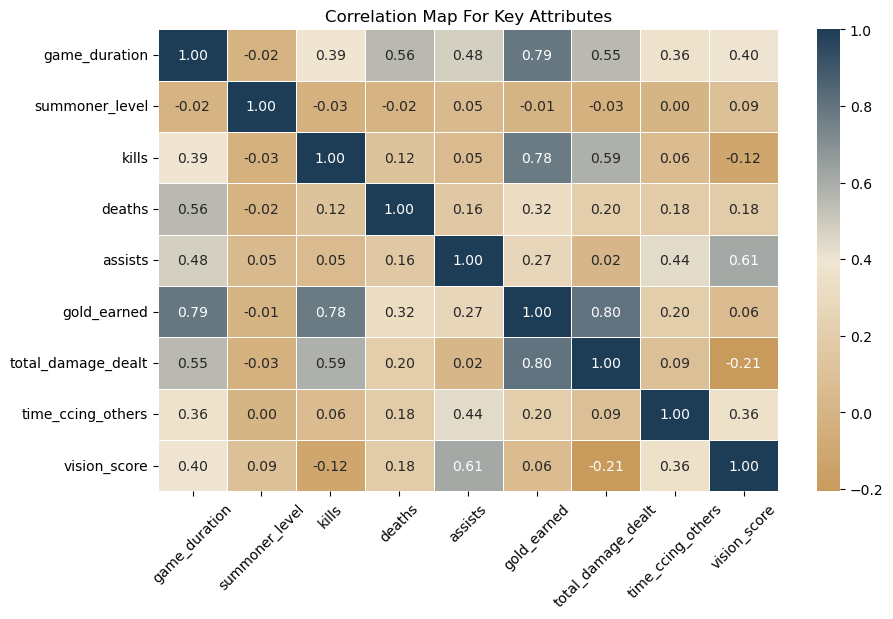

In [80]:
corr_matrix = sr_clean[summ_columns].corr()

league_cmap_colors = ["#c89b5d", "#F0E6D2", "#1d3c56"]
league_c_scale = LinearSegmentedColormap.from_list("league_c_scale", league_cmap_colors, N=256)

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap=league_c_scale, linewidths=0.5, fmt='.2f')
plt.xticks(rotation = 45)

# Add title and labels
plt.title('Correlation Map For Key Attributes')
plt.show()

<Axes: xlabel='summoner_level', ylabel='Count'>

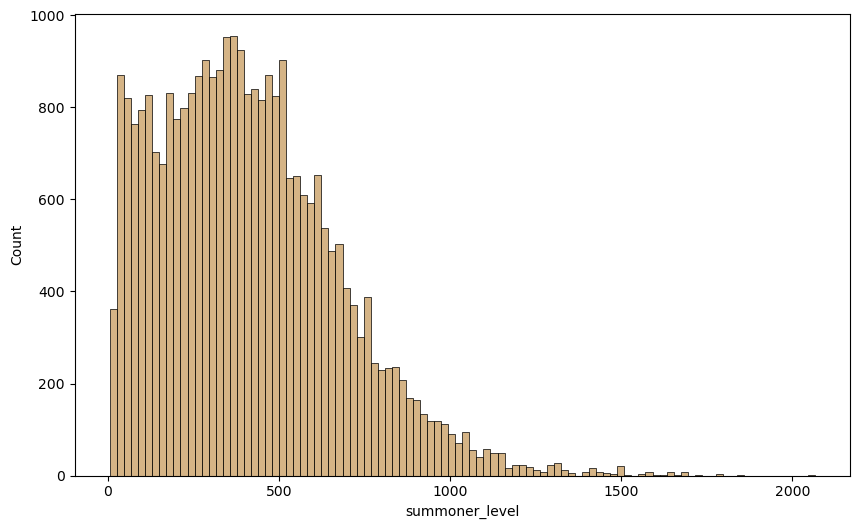

In [82]:
plt.figure(figsize = (10,6))
sns.histplot(data = sr_clean, x = 'summoner_level', bins = 100, color = '#c89b5d')

Right skewed, may need to log transform if we see poor performance.

## **Performance By Position Analysis**

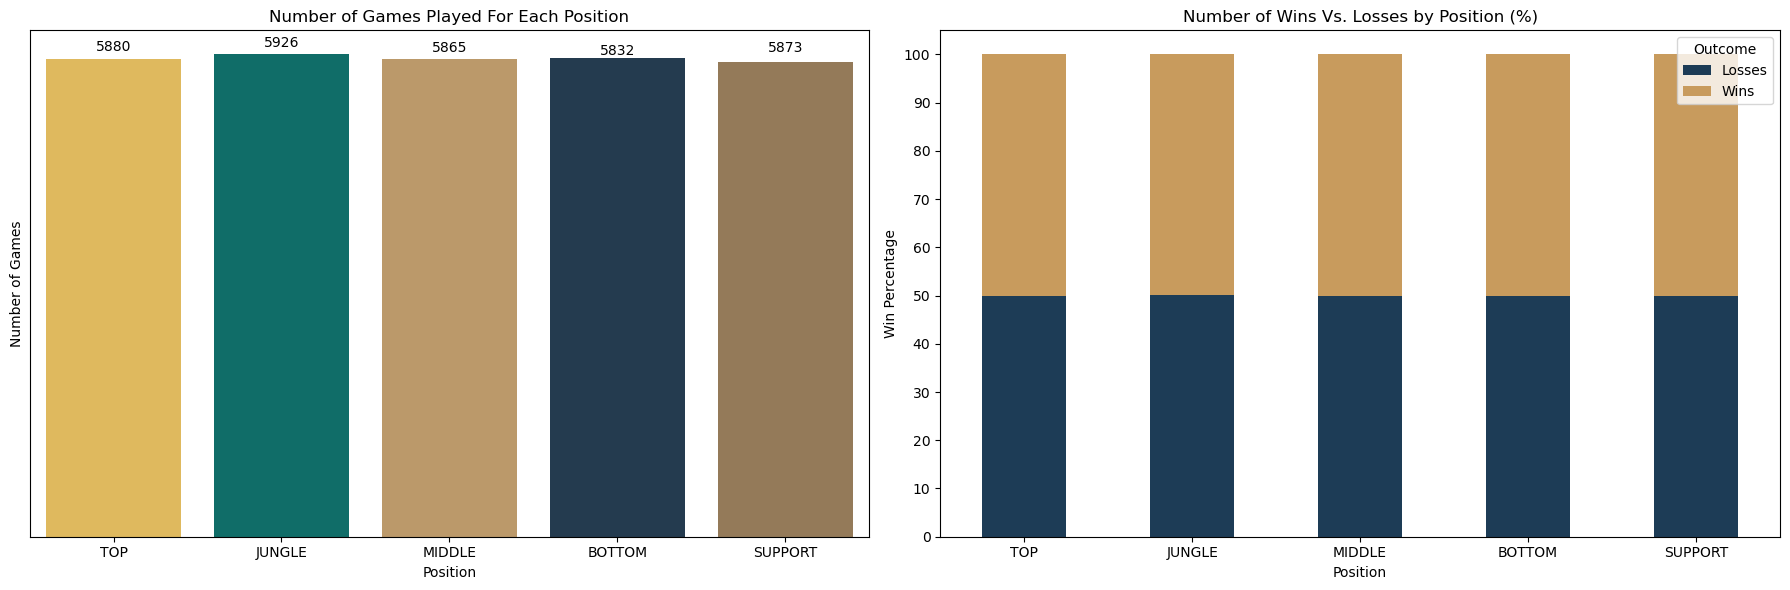

In [86]:
position_order = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'SUPPORT']

position_wins = sr_clean.groupby(['individual_position', 'win']).size().unstack()
position_wins_percent = round(position_wins.div(position_wins.sum(axis=1), axis=0) * 100, 2)
position_wins_percent = position_wins_percent.reindex(position_order)

roles = sr_clean.groupby("individual_position").size().reset_index(name="count")


# Create Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

league_palette = sns.color_palette(["#1d3c56", "#007d76", "#c89b5d", "#9e7b4f", "#f4c249"])

# Set the custom palette
sns.set_palette(league_palette)


# First Plot: Number of Games Per Position (Bar Chart)
sns.barplot(data=roles, x='individual_position', y='count', palette = league_palette, order = position_order,
            hue = 'individual_position', ax=axes[0])
axes[0].set_title("Number of Games Played For Each Position")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Number of Games")
axes[0].set_yticks([])  # Hide y-ticks
for index, row in roles.iterrows():
    axes[0].text(x=index, y=row['count'] + 50, s=row['count'], ha='center', va='bottom', fontsize=10)

league_colors = ["#1d3c56", "#c89b5d"]

# Second Plot: Stacked Bar Chart (Win Percentage)
position_wins_percent.plot(kind='bar', stacked=True, ax=axes[1], color = league_colors)
axes[1].set_title("Number of Wins Vs. Losses by Position (%)")
axes[1].set_xlabel("Position")
axes[1].set_ylabel("Win Percentage")
axes[1].legend(["Losses", "Wins"], title="Outcome")
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_yticks(range(0, 101, 10))


# Adjust layout
plt.tight_layout()
plt.show()

In [88]:
ver_position_wins = sr_clean.groupby(['game_version', 'individual_position', 'win']).size().unstack()

# Calculate win percentage for each position within each game version
ver_position_wins_percent = round(ver_position_wins.div(ver_position_wins.sum(axis=1), axis=0) * 100, 2)

ver_position_wins_percent = ver_position_wins_percent['TRUE']

In [90]:
ver_position_wins_percent = ver_position_wins_percent.reindex(position_order, level='individual_position')
ver_position_wins_percent = ver_position_wins_percent.unstack(level='individual_position')
ver_position_wins_percent

individual_position,TOP,JUNGLE,MIDDLE,BOTTOM,SUPPORT
game_version,,,,,
14.16.609.8277,50.00,50.00,50.00,50.00,50.00
14.17.615.2328,50.00,50.00,50.00,50.00,50.00
14.18.616.8335,50.00,50.00,50.00,50.00,50.00
14.21.630.3012,50.00,50.00,50.00,50.00,50.00
14.22.633.1362,50.00,50.00,50.00,50.00,50.00
14.22.635.4945,50.00,50.00,50.00,50.00,50.00
14.23.636.9832,50.00,50.00,50.00,47.83,55.00
14.24.642.1879,50.00,50.00,50.00,50.00,50.00
14.24.643.5128,50.00,50.00,50.00,50.00,50.00


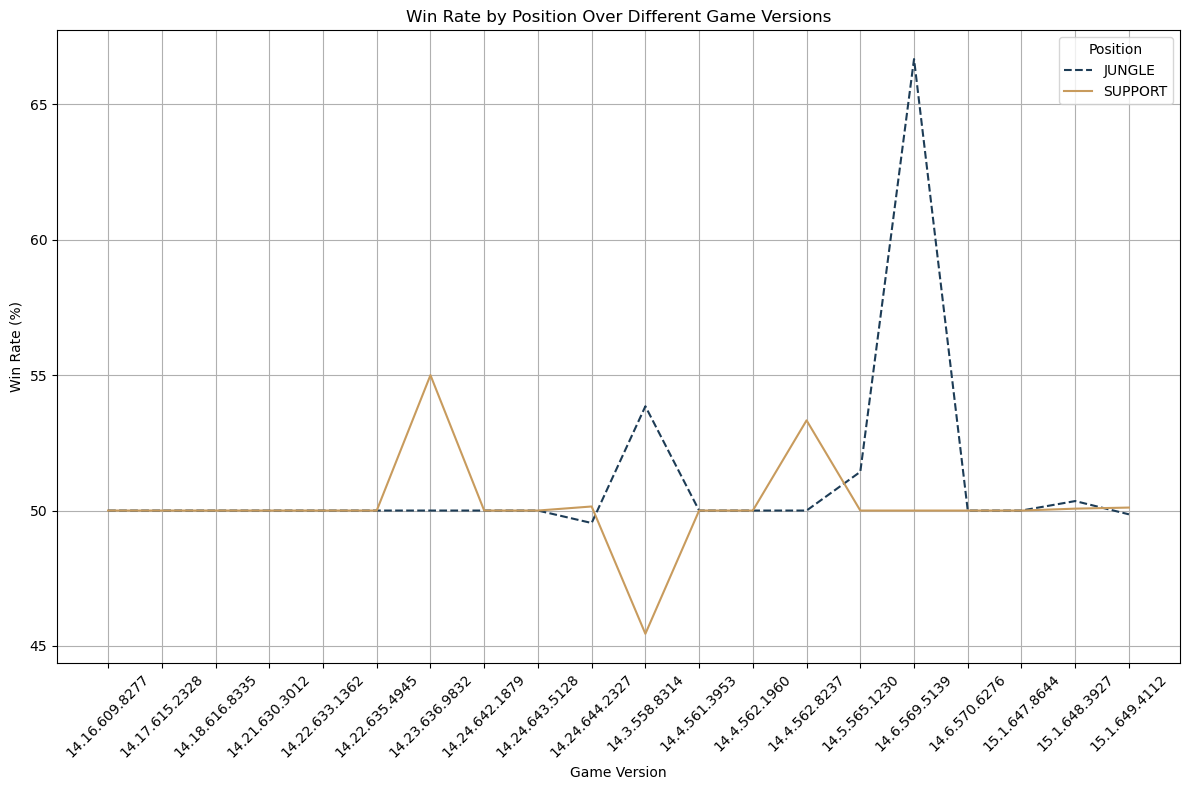

In [92]:
plt.figure(figsize=(12, 8))

plt.plot(ver_position_wins_percent.index, ver_position_wins_percent['JUNGLE'], label= 'JUNGLE',
         color = '#1d3c56', linestyle = '--')
plt.plot(ver_position_wins_percent.index, ver_position_wins_percent['SUPPORT'], label= 'SUPPORT', color = '#c89b5d')

# Customize plot
plt.title('Win Rate by Position Over Different Game Versions')
plt.xlabel('Game Version')
plt.ylabel('Win Rate (%)')
plt.legend(title='Position')
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

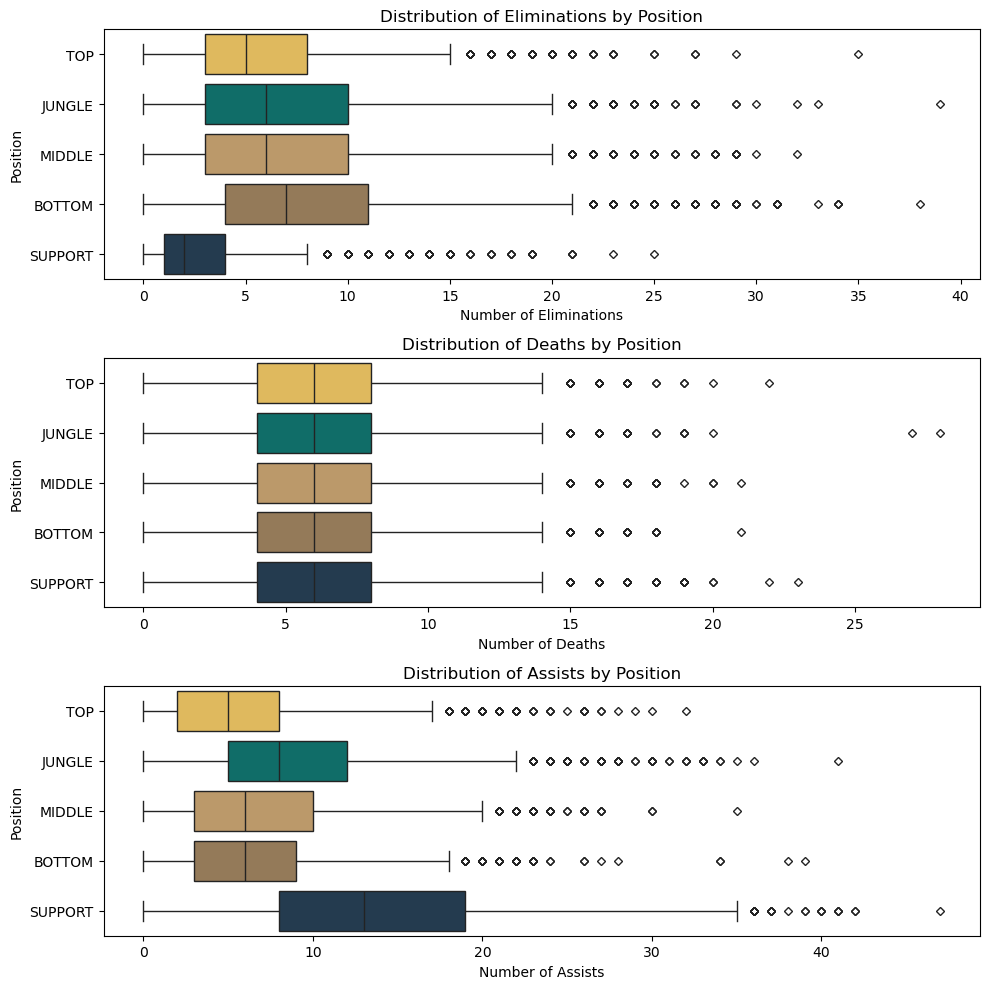

In [94]:
# Create a boxplot for kills, deaths, and assists by position
plt.figure(figsize=(10, 10))

flierprops = dict(marker = 'D', markersize = 4)


# Plot kills
plt.subplot(3, 1, 1)
sns.boxplot(x = 'kills', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, order = position_order)
plt.title('Distribution of Eliminations by Position')
plt.xlabel('Number of Eliminations')
plt.ylabel('Position')


# Plot deaths
plt.subplot(3, 1, 2)
sns.boxplot(x = 'deaths', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, order = position_order)
plt.title('Distribution of Deaths by Position')
plt.xlabel('Number of Deaths')
plt.ylabel('Position')


# Plot assists
plt.subplot(3, 1, 3)
sns.boxplot(x = 'assists', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, order = position_order)
plt.title('Distribution of Assists by Position')
plt.xlabel('Number of Assists')
plt.ylabel('Position')


# Show plots
plt.tight_layout()
plt.show()

## **Game Duration Analysis**

In [99]:
sr_clean.loc[:, 'kda'] = (sr_clean.loc[:,'kills'] + sr_clean.loc[:, 'assists'])/sr_clean.loc[:, 'deaths']
sr_clean.loc[:,'gold/min'] = sr_clean.loc[:, 'gold_earned']/(sr_clean.loc[:, 'game_duration']/60)

In [101]:
sr_clean.loc[:, 'kda'] = sr_clean.loc[:, 'kda'].fillna(float('inf'))

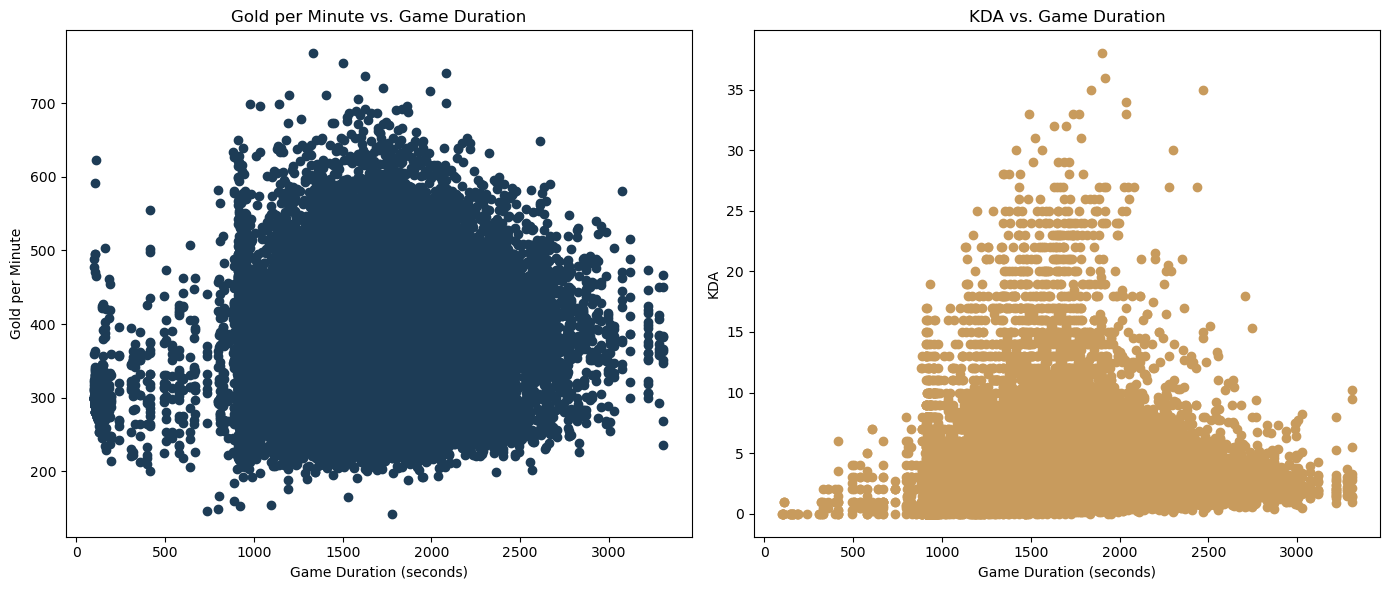

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for Gold per Minute vs. Game Duration
axes[0].scatter(sr_clean['game_duration'], sr_clean['gold/min'], color='#1d3c56')
axes[0].set_xlabel('Game Duration (seconds)')
axes[0].set_ylabel('Gold per Minute')
axes[0].set_title('Gold per Minute vs. Game Duration')

# Scatter plot for KDA vs. Game Duration
axes[1].scatter(sr_clean['game_duration'], sr_clean['kda'], color='#c89b5d')
axes[1].set_xlabel('Game Duration (seconds)')
axes[1].set_ylabel('KDA')
axes[1].set_title('KDA vs. Game Duration')

# Show plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

## **Performance Analysis Based on Solo Rank**

Gold Earned, Vision Score and Total damage dealt depending on rank

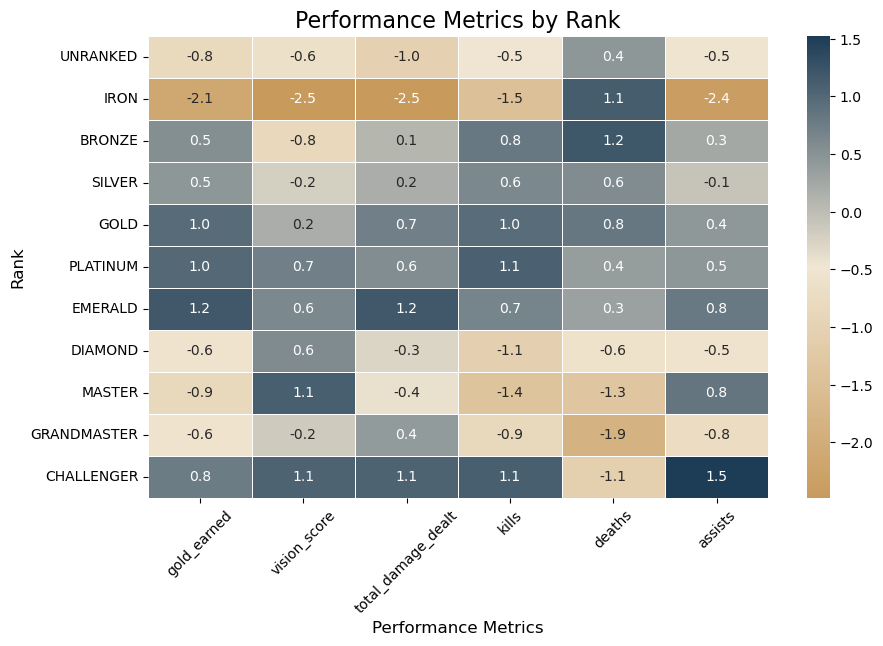

In [107]:
ranks = sr_clean.groupby('solo_tier')[['gold_earned', 'vision_score', 'total_damage_dealt', 'kills', 
                                       'deaths', 'assists']].mean()
rank_order = ['UNRANKED', 'IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD',
              'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
ranks = ranks.reindex(rank_order)

scaler = StandardScaler()
ranks_standardized = pd.DataFrame(scaler.fit_transform(ranks), columns=ranks.columns, index=ranks.index)


plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(ranks_standardized, annot=True, fmt=".1f", cmap=league_c_scale, linewidths=0.5)

# Add title and labels
plt.title('Performance Metrics by Rank', fontsize=16)
plt.xlabel('Performance Metrics', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.xticks(rotation = 45)

# Show the plot
plt.show()

## **Match Outcome Classifier**

In [110]:
X = sr_clean.drop(columns=['win', 'game_id', 'summoner_id', 'day', 'year', 'kda', 'gold/min', 'game_mode'])  # Replace 'target' with your actual target column
y = sr_clean['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [112]:
X.dtypes

game_duration                         float64
game_version                           object
summoner_level                        float64
champion_name                          object
team_id                               float64
individual_position                    object
kills                                 float64
deaths                                float64
assists                               float64
gold_earned                           float64
gold_spent                            float64
total_damage_dealt                    float64
physical_damage_dealt_to_champions    float64
magic_damage_dealt_to_champions       float64
true_damage_dealt_to_champions        float64
damage_dealt_to_objectives            float64
damage_dealt_to_turrets               float64
physical_damage_taken                 float64
magic_damage_taken                    float64
true_damage_taken                     float64
time_ccing_others                     float64
vision_score                      

In [114]:
cat_columns = ['game_version', 'champion_name', 'individual_position', 'solo_tier',
               'solo_rank', 'is_weekend', 'month', 'day_of_week']
train_pool = Pool(X_train, label = y_train, cat_features=cat_columns)
test_pool = Pool(X_test, label = y_test, cat_features=cat_columns)

In [116]:
params = {
    'iterations': 500,  # Number of boosting rounds
    'depth': 10,         # Depth of trees
    'learning_rate': 0.1,  # Step size
    'loss_function': 'Logloss',  # Suitable for binary classification
    'custom_metric': ['AUC', 'Accuracy', 'Logloss'], # Evaluation metric
    'verbose': False,  # Suppress training output
    'random_seed': 100
}

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)


In [117]:
model_metrics = model.eval_metrics(test_pool, ['AUC', 'Logloss', 'Accuracy'])

max_auc = max(model_metrics['AUC'])
max_accuracy = max(model_metrics['Accuracy'])
min_logloss = min(model_metrics['Logloss'])

performance_measures = [["Area Under The Curve (%)", round(max_auc * 100, 2)],
                        ["Accuracy (%)", round(max_accuracy * 100, 2)],
                        ["Logloss", round(min_logloss, 2)]]
# defining headings
headings = ["Metric", "Value"]

# creating and displaying table
performance_table = tabulate(performance_measures, headings, tablefmt="simple_grid")
print(performance_table)

┌──────────────────────────┬─────────┐
│ Metric                   │   Value │
├──────────────────────────┼─────────┤
│ Area Under The Curve (%) │   95.36 │
├──────────────────────────┼─────────┤
│ Accuracy (%)             │   88.39 │
├──────────────────────────┼─────────┤
│ Logloss                  │    0.27 │
└──────────────────────────┴─────────┘


In [118]:
# Perform cross-validation
cv_results = cv(
    params = params,
    pool = train_pool,
    fold_count = 5,  # Number of folds
    stratified = True,  # Stratified sampling
    partition_random_seed = 100,
    shuffle = True,
    verbose = 0
)

Training on fold [0/5]

bestTest = 0.2648944225
bestIteration = 301

Training on fold [1/5]

bestTest = 0.2808109123
bestIteration = 322

Training on fold [2/5]

bestTest = 0.2969864479
bestIteration = 317

Training on fold [3/5]

bestTest = 0.2814624585
bestIteration = 328

Training on fold [4/5]

bestTest = 0.2891107212
bestIteration = 253



In [119]:
cv_max_auc = max(cv_results['test-AUC-mean'])
cv_max_accuracy = max(cv_results['test-Accuracy-mean'])
cv_min_logloss = min(cv_results['test-Logloss-mean'])

cv_performance_measures = [["Area Under The Curve (%)", round(cv_max_auc * 100, 2)],
                           ["Accuracy (%)", round(cv_max_accuracy * 100, 2)],
                           ["Logloss", round(cv_min_logloss, 2)]]
# defining headings
headings = ["Metric", "Value"]

# creating and displaying table
cv_performance_table = tabulate(cv_performance_measures, headings, tablefmt="simple_grid")
print(cv_performance_table)

┌──────────────────────────┬─────────┐
│ Metric                   │   Value │
├──────────────────────────┼─────────┤
│ Area Under The Curve (%) │   95.19 │
├──────────────────────────┼─────────┤
│ Accuracy (%)             │   87.87 │
├──────────────────────────┼─────────┤
│ Logloss                  │    0.28 │
└──────────────────────────┴─────────┘


In [120]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]
y_pred_probs

array([0.22885443, 0.26685697, 0.9843142 , ..., 0.94105782, 0.9981886 ,
       0.25217716])

In [121]:
len(y_pred_probs)

5876

In [122]:
win_prob_data = X_test
win_prob_data['Win_probability'] = y_pred_probs
win_prob_data

,game_duration,game_version,summoner_level,champion_name,team_id,individual_position,kills,deaths,assists,gold_earned,...,final_attackSpeed,final_healthMax,final_magicResist,final_movementSpeed,month,day_of_week,is_weekend,hour,minute,Win_probability
25974,1989.0,15.1.649.4112,273.0,Cassiopeia,200.0,MIDDLE,2.0,8.0,9.0,9717.0,...,121.0,3150.0,53.0,411.0,1.0,4.0,False,18.0,18.0,0.228854
32,103.0,15.1.648.3927,1582.0,Smolder,100.0,BOTTOM,0.0,0.0,0.0,507.0,...,100.0,665.0,30.0,330.0,1.0,1.0,False,0.0,29.0,0.266857
8041,915.0,15.1.649.4112,595.0,Maokai,200.0,SUPPORT,1.0,2.0,9.0,4834.0,...,122.0,1889.0,79.0,380.0,1.0,4.0,False,20.0,49.0,0.984314
13767,1672.0,15.1.649.4112,469.0,Lucian,100.0,BOTTOM,10.0,6.0,1.0,11003.0,...,142.0,1920.0,65.0,390.0,1.0,2.0,False,0.0,14.0,0.005650
36512,1624.0,15.1.649.4112,87.0,Draven,100.0,BOTTOM,18.0,3.0,5.0,19956.0,...,245.0,2374.0,90.0,418.0,1.0,5.0,True,21.0,0.0,0.990393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6673,1825.0,15.1.649.4112,632.0,Twitch,200.0,BOTTOM,6.0,6.0,7.0,12574.0,...,233.0,2032.0,45.0,440.0,1.0,4.0,False,17.0,11.0,0.304097
35091,1945.0,15.1.649.4112,113.0,Diana,100.0,MIDDLE,6.0,8.0,5.0,12686.0,...,161.0,2377.0,61.0,431.0,1.0,2.0,False,16.0,19.0,0.078556
4421,2031.0,15.1.649.4112,711.0,Riven,200.0,TOP,7.0,3.0,8.0,17122.0,...,164.0,3000.0,76.0,413.0,1.0,0.0,False,0.0,40.0,0.941058
20851,1913.0,15.1.649.4112,350.0,Darius,200.0,TOP,12.0,4.0,6.0,15735.0,...,152.0,4370.0,226.0,426.0,1.0,4.0,False,2.0,25.0,0.998189


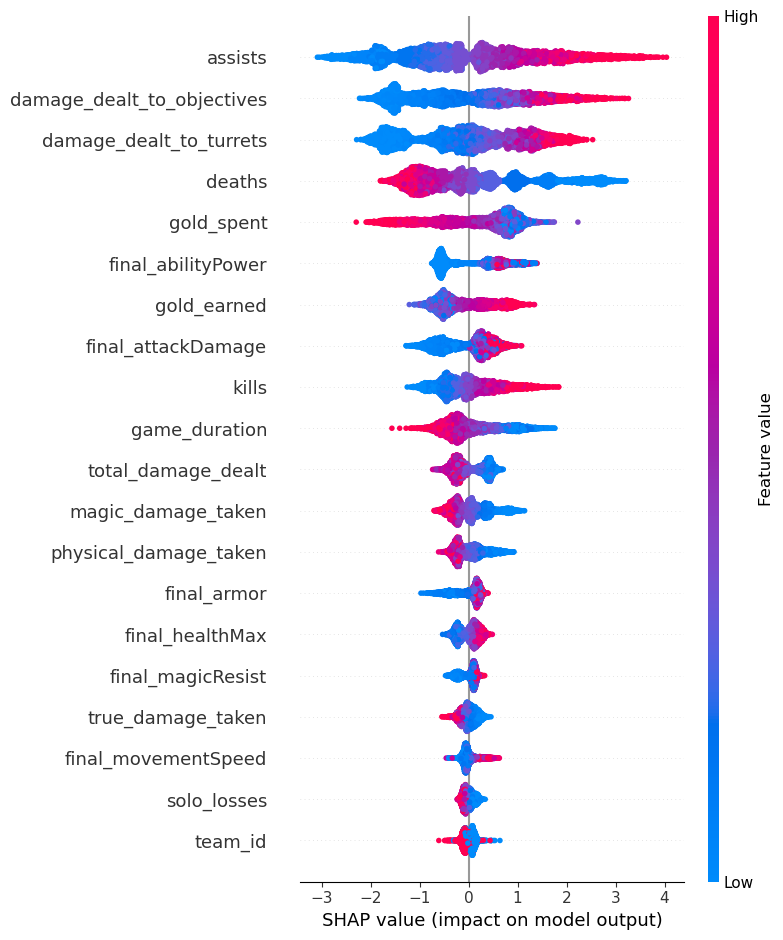

In [123]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot to show feature importance and relationships
shap.summary_plot(shap_values, X_test)# Extract SHAP values for the champion feature


In [124]:
champion_shap = pd.DataFrame({
    "Champion": X_test['champion_name'],
    "abs_shap": abs(shap_values[:, X_test.columns.get_loc('champion_name')])
})

champion_importance = champion_shap.groupby("Champion")["abs_shap"].mean().sort_values(ascending=False)

# Display the top champions influencing win probability
print(champion_importance.head(10))

Champion
Fiora        0.134316
Ryze         0.118894
Nami         0.112670
Samira       0.111780
KSante       0.108502
Kled         0.104783
Wukong       0.102140
Yone         0.098477
Seraphine    0.095836
XinZhao      0.094688
Name: abs_shap, dtype: float64


## **References**

https://activeplayer.io/league-of-legends/ (player count statement)